In [1]:
# %matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from halotools.empirical_models import PrebuiltHodModelFactory
from halotools.sim_manager import CachedHaloCatalog
from halotools import sim_manager
from halotools.mock_observables import return_xyz_formatted_array
# from halotools.mock_observables import wp
import halotools.sim_manager.sim_defaults as sim_defaults
from halotools.mock_observables import mock_survey
# from halotools.mock_observables import angular_tpcf


sim_defaults.default_simname = 'multidark'
sim_defaults.default_redshift = 0.5 # multidark actual z = 0.466

In [ ]:
# Download halo catalogs (only needs to be done once)
# from halotools.sim_manager import DownloadManager
# dman = DownloadManager()
# dman.download_processed_halo_table('multidark', 'rockstar', 0.5) 

In [2]:
# get Multidark + ROCKSTAR halo catalog

halocat = CachedHaloCatalog(simname = 'multidark', halo_finder = 'rockstar', \
                            version_name = 'halotools_v0p4', redshift = 0.5)

In [3]:
# zheng07 HOD model
# https://halotools.readthedocs.io/en/latest/quickstart_and_tutorials/tutorials/model_building/preloaded_models/zheng07_composite_model.html

HODmodel = PrebuiltHodModelFactory('zheng07', threshold = -21, redshift = 0.5)

# values from Rongpu's LRG analysis (see Slack message)
HODmodel.param_dict['logMmin'] = 12.89376701 # Minimum mass required for a halo to host a central galaxy.
HODmodel.param_dict['sigma_logM'] = 0.23939566 # Rate of transition from ⟨Ncen⟩=0⇒⟨Ncen=1⟩
HODmodel.param_dict['logM0'] = 12.26827089 # Low-mass cutoff in ⟨Nsat⟩
HODmodel.param_dict['logM1'] = 14.03372441 # Characteristic halo mass where ⟨Nsat⟩ begins to assume a power law form.
HODmodel.param_dict['alpha'] = 1.32828278 # Power law slope of the relation between halo mass and ⟨Nsat⟩.
HODmodel.param_dict

{'logMmin': 12.89376701,
 'sigma_logM': 0.23939566,
 'logM0': 12.26827089,
 'logM1': 14.03372441,
 'alpha': 1.32828278}

In [4]:
# Create mock galaxy catalog

HODmodel.populate_mock(halocat)

gals = HODmodel.mock.galaxy_table
# gals[3] # sample
# gals.info

/home/tjr63/miniconda3/envs/halotools_env/lib/python3.7/site-packages/halotools/empirical_models/phase_space_models/analytic_models/monte_carlo_helpers.py:205: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.rad_prof_func_table_indices[digitized_param_list]
/home/tjr63/miniconda3/envs/halotools_env/lib/python3.7/site-packages/halotools/empirical_models/phase_space_models/analytic_models/monte_carlo_helpers.py:522: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.rad_prof_func_table_indices[digitized_param_list]


In [ ]:
gals.info

In [ ]:
np.asarray(gals['x'])

In [ ]:
coords = np.vstack([gals['x'], gals['y'], gals['z']]).T
type(coords)

In [ ]:
?ax.scatter3D

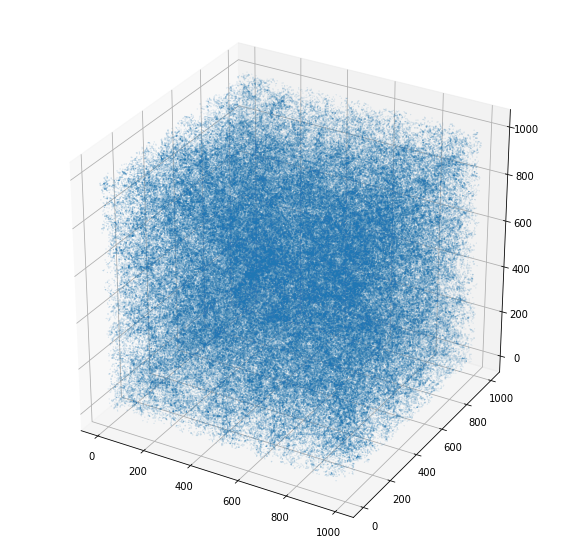

In [6]:
from mpl_toolkits import mplot3d
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(np.asarray(gals['x']), np.asarray(gals['y']), np.asarray(gals['z']), \
            s=0.01)
# plt.xlabel('x')
# plt.ylabel('y')
# plt.zlabel('z')
# plt.show()

In [ ]:
import Corrfunc

In [ ]:
boxsize = halocat.Lbox[0]
nthreads = 1
bins = np.linspace(75,125, 20)
x = np.array(gals['x'])
y = np.array(gals['y'])
z = np.array(gals['z'])


In [ ]:
xiresults = Corrfunc.theory.xi(boxsize, nthreads, bins, x, y, z)
# fields: rmin, rmax, ravg, xi, npairs, weightavg

In [ ]:
xi_field_list = ['rmin', 'rmax', 'ravg', 'xi', 'npairs', 'weightavg']

rcen = (xiresults['rmin'] + xiresults['rmax']) / 2.
xivals = xiresults['xi']

In [ ]:
plt.figure()
plt.scatter(rcen, xivals)
plt.xlabel('rcen')
plt.ylabel('xi')
plt.show()

In [ ]:
?Corrfunc.theory.wp

In [ ]:
pi_max_list = [75, 125, 200, 250, 300]
wpresults = {}

for pi_max in pi_max_list:
    wpresults[pi_max] = Corrfunc.theory.wp(boxsize, pi_max, nthreads, bins, x, y, z)

In [ ]:
wp_field_list = ['rpmin', 'rpmax', 'rpavg', 'wp', 'npairs', 'weightavg']



In [ ]:
plt.figure()

for pi_max, wpres in wpresults.items():
    rcen = (wpres['rmin'] + wpres['rmax']) / 2.
    wpvals = wpres['wp']
    plt.plot(rcen, wpvals, label=r'$\pi_{max}$ = '+str(pi_max))
plt.xlabel('rcen')
plt.ylabel('wp')
plt.legend()
plt.show()

# Old

In [ ]:
# mask = model.mock.galaxy_table['stellar_mass'] > 10**10.5
gals = HODmodel.mock.galaxy_table
coords = np.vstack([gals['x'], gals['y'], gals['z']]).T
vels = np.vstack([gals['vx'], gals['vy'], gals['vz']]).T

In [ ]:
ra, dec, z = mock_survey.ra_dec_z(coords, vels)#, cosmo=model.mock.cosmology)
ra = np.degrees(ra)
dec = np.degrees(dec)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(ra,dec,'.',color='red')
plt.xlim([-180,180])
plt.ylim([-90,90])
plt.ylabel(r'$\delta$  $[{\rm degrees}]$', fontsize=20)
plt.xlabel(r'$\alpha$  $[{\rm degrees}]$', fontsize=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.tight_layout()
plt.title('Mock catalog in angular coordinates', fontsize=20)

In [ ]:
# using randoms:

Nran=10**5
ran_coords = np.random.random((Nran,3))*model.mock.Lbox
ran_vels = np.zeros((Nran,3))

ran_ra, ran_dec, ran_z = mock_survey.ra_dec_z(ran_coords, ran_vels)#, cosmo=model.mock.cosmology)
ran_ra = np.degrees(ran_ra)
ran_dec = np.degrees(ran_dec)

In [ ]:

angular_coords = np.vstack((ra,dec)).T
ran_angular_coords = np.vstack((ran_ra,ran_dec)).T

theta_bins = np.logspace(-2,0,15)
cen_theta_bins = (theta_bins[:-1]+theta_bins[1:])/2.0

w_theta_with_randoms = angular_tpcf(angular_coords, theta_bins, \
                                    randoms=ran_angular_coords, num_threads='max')

In [ ]:
plt.figure()
plt.plot(cen_theta_bins,1.0+w_theta_with_randoms,'o-')
plt.loglog()
plt.ylabel(r'$1+w_{\theta}$', fontsize=20)
plt.xlabel(r'$\theta$  $[{\rm degrees}]$', fontsize=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title('Angular correlation function', fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
# without randoms
coords = np.vstack((gals['x'],gals['y'],gals['z'])).T - HODmodel.mock.Lbox/2.0
vels = np.vstack((gals['vx'],gals['vy'],gals['vz'])).T

ra_init, dec_init, z = mock_survey.ra_dec_z(coords, vels)#, cosmo=model.mock.cosmology)

#keep a complete spherical volume
r = np.sqrt(coords[:,0]**2 + coords[:,1]**2 + coords[:,2]**2)
# keep = r<model.mock.Lbox/2.0
keep = r<np.sqrt(np.sum(HODmodel.mock.Lbox[:]**2))/2.0

ra = np.degrees(ra_init[keep])
dec = np.degrees(dec_init[keep])

In [ ]:
plt.figure()
plt.plot(ra,dec,'.',color='blue', ms=0.01)
plt.xlim([-180,180])
plt.ylim([-90,90])
plt.ylabel(r'$\delta$  $[{\rm degrees}]$', fontsize=20)
plt.xlabel(r'$\alpha$  $[{\rm degrees}]$', fontsize=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.tight_layout()
plt.title('Mock catalog in angular coordinates', fontsize=20)
plt.show()

In [ ]:
theta_bins = np.logspace(-2,0,150)
cen_theta_bins = (theta_bins[:-1]+theta_bins[1:])/2.0


angular_coords = np.vstack((ra,dec)).T
w_theta = angular_tpcf(angular_coords, theta_bins, num_threads='max')

In [ ]:


plt.figure()
# plt.plot(cen_theta_bins,1.0+w_theta,'o-', label='analytic randoms')
plt.plot(cen_theta_bins,w_theta,'o-', label='analytic randoms')
# plt.plot(cen_theta_bins,1.0+w_theta_with_randoms,'o-', label = 'manual randoms')
plt.loglog()
plt.ylabel(r'$w_{\theta}$', fontsize=20)
plt.xlabel(r'$\theta$  $[{\rm degrees}]$', fontsize=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title('Angular correlation function', fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.tight_layout()
plt.show()

# Older

In [ ]:
rr, xi_cc, xi_cs, xi_ss = zheng07_model.compute_average_galaxy_clustering(\
                            gal_type = 'centrals', include_crosscorr = True, \
                            num_iterations = 3, num_threads = 'max') 

In [ ]:
# https://halotools.readthedocs.io/en/latest/api/halotools.empirical_models.ModelFactory.html#halotools.empirical_models.ModelFactory.compute_average_galaxy_clustering
# "The compute_average_galaxy_clustering is simply a convenience function, and is not intended for use in performance-critical applications such as MCMCs"

rbins = np.linspace(45,200, num=50)

r, xi_gg = HODmodel.compute_average_galaxy_clustering(rbins=rbins, simname='multidark')

In [ ]:
# Plot 3D correlation function

plt.figure()
plt.scatter(r,xi_gg)
# plt.loglog()
plt.axis([45,200, -0.001,0.004])
plt.xlabel(r'$r $  $\rm{[Mpc/h]}$')
plt.ylabel('xi_gg')
plt.show()

In [ ]:
rp_bins = np.logspace(-1,1.25,15)
from halotools.mock_observables import wp


In [ ]:
# 2D correlation funciton, w_p
# following- https://halotools.readthedocs.io/en/latest/quickstart_and_tutorials/tutorials/catalog_analysis/galcat_analysis/basic_examples/clustering_examples/galaxy_catalog_analysis_tutorial4.html#galaxy-catalog-analysis-tutorial4
# and- https://halotools.readthedocs.io/en/latest/api/halotools.mock_observables.wp.html#halotools.mock_observables.wp
x = gals['x']
y = gals['y']
z = gals['z']
pos = return_xyz_formatted_array(x, y, z)


pi_max = 125.

w_p = wp(pos, bins, pi_max, period=HODmodel.mock.Lbox, num_threads='max')

In [ ]:
# Plot w_p
bin_centers = (bins[:-1] + bins[1:])/2.

plt.figure()
plt.plot(bin_centers, w_p)
# plt.axis([45,200, -0.2,1.])
plt.xlabel(r'$r $  $\rm{[Mpc/h]}$')
plt.ylabel('w_p')
plt.show()

In [ ]:
rp_bin_centers = (rbins[:-1] + rbins[1:])/2.
rbins[:-1]

In [ ]:
rp_bin_centers

In [ ]:
?zheng07_model.compute_average_galaxy_clustering

In [ ]:
?PrebuiltHodModelFactory